## 1. Five years of company statements ##

### 1.1 Raw statements downloaded from Alpha Vantage ###

We download three JSON files to `data_raw/alphavantage/`:
- Income statement
- Balance sheet
- Cash flow

In [11]:
%pip install pandas numpy requests python-dotenv matplotlib

Note: you may need to restart the kernel to use updated packages.


In [12]:
import os, json, time
from pathlib import Path

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

from dotenv import load_dotenv

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


In [13]:
if Path("secrets.env").exists():
    load_dotenv("secrets.env")

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "").strip()
if not API_KEY:
    raise RuntimeError("Missing ALPHAVANTAGE_API_KEY. Set env var or create secrets.env")

SYMBOL = "NVDA"


In [14]:
AV_BASE = "https://www.alphavantage.co/query"

FUNCTIONS = {
    "income_statement": "INCOME_STATEMENT",
    "balance_sheet": "BALANCE_SHEET",
    "cash_flow": "CASH_FLOW",
}

RAW_DIR = Path("data_raw/alphavantage")
RAW_DIR.mkdir(parents=True, exist_ok=True)

def fetch_av_json(function: str, symbol: str, api_key: str) -> dict:
    params = {"function": function, "symbol": symbol, "apikey": api_key}
    r = requests.get(AV_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    if "Error Message" in data:
        raise RuntimeError(f"Alpha Vantage error: {data['Error Message']}")
    if "Note" in data:
        raise RuntimeError(f"Alpha Vantage rate limit: {data['Note']}")
    return data

def save_json(data: dict, path: Path) -> None:
    path.write_text(json.dumps(data, indent=2), encoding="utf-8")

paths = {}
for name, fn in FUNCTIONS.items():
    out_path = RAW_DIR / f"{SYMBOL}_{name}.json"
    # If already downloaded, reuse (reproducible + avoids rate limit)
    if out_path.exists():
        paths[name] = out_path
        continue
    data = fetch_av_json(fn, SYMBOL, API_KEY)
    save_json(data, out_path)
    paths[name] = out_path
    time.sleep(12) 

paths


{'income_statement': PosixPath('data_raw/alphavantage/NVDA_income_statement.json'),
 'balance_sheet': PosixPath('data_raw/alphavantage/NVDA_balance_sheet.json'),
 'cash_flow': PosixPath('data_raw/alphavantage/NVDA_cash_flow.json')}

### 1.2 Standardize FY2021–FY2025 statements into clean tables

> Note: Alpha Vantage uses fiscal year ending dates; we label fiscal year by the year in `fiscalDateEnding`.


In [64]:
YEARS = {2020,2021, 2022, 2023, 2024, 2025}

def load_reports(path: Path) -> list[dict]:
    data = json.loads(path.read_text(encoding="utf-8"))
    reps = data.get("annualReports", [])
    if not reps:
        raise RuntimeError(f"No annualReports found in {path}")
    return reps

def year_from_fiscal_date(s: str) -> int:
    return int(s[:4])

def to_int(x):
    try:
        return int(float(x))
    except Exception:
        return pd.NA

def standardize_income(path: Path) -> pd.DataFrame:
    reps = load_reports(path)
    rows = []
    for r in reps:
        y = year_from_fiscal_date(r["fiscalDateEnding"])
        if y not in YEARS:
            continue
        rows.append({
            "fiscal_year": y,
            "fiscal_date_ending": r["fiscalDateEnding"],
            "revenue": to_int(r.get("totalRevenue")),
            "cogs": to_int(r.get("costOfRevenue")),
            "gross_profit": to_int(r.get("grossProfit")),
            "operating_income": to_int(r.get("operatingIncome")),
            "net_income": to_int(r.get("netIncome")),
            "interest_expense": to_int(r.get("interestExpense")),
            "income_before_tax": to_int(r.get("incomeBeforeTax")),
            "income_tax_expense": to_int(r.get("incomeTaxExpense")),
        })
    return pd.DataFrame(rows).sort_values("fiscal_year").reset_index(drop=True)

def standardize_balance(path: Path) -> pd.DataFrame:
    reps = load_reports(path)
    rows = []
    for r in reps:
        y = year_from_fiscal_date(r["fiscalDateEnding"])
        if y not in YEARS:
            continue
        rows.append({
            "fiscal_year": y,
            "fiscal_date_ending": r["fiscalDateEnding"],
            "total_assets": to_int(r.get("totalAssets")),
            "total_liabilities": to_int(r.get("totalLiabilities")),
            "total_shareholder_equity": to_int(r.get("totalShareholderEquity")),
            "cash_and_cash_equivalents": to_int(r.get("cashAndCashEquivalentsAtCarryingValue")),
            "current_assets": to_int(r.get("totalCurrentAssets")),
            "current_liabilities": to_int(r.get("totalCurrentLiabilities")),
            "long_term_debt": to_int(r.get("longTermDebt")),
            "short_term_debt": to_int(r.get("shortTermDebt")),
            "short_term_investments": to_int(r.get("shortTermInvestments")),
        })
    return pd.DataFrame(rows).sort_values("fiscal_year").reset_index(drop=True)

def standardize_cashflow(path: Path) -> pd.DataFrame:
    reps = load_reports(path)
    rows = []
    for r in reps:
        y = year_from_fiscal_date(r["fiscalDateEnding"])
        if y not in YEARS:
            continue

        cfo = to_int(r.get("operatingCashflow"))
        capex = to_int(r.get("capitalExpenditures"))

        # AV often stores capex as negative; convert to positive cash outflow
        if pd.notna(capex):
            capex_outflow = abs(capex)
        else:
            capex_outflow = pd.NA

        da = to_int(r.get("depreciationDepletionAndAmortization"))

        # FCF = CFO - Capex(outflow)
        if pd.notna(cfo) and pd.notna(capex_outflow):
            fcf = cfo - capex_outflow
        else:
            fcf = pd.NA

        rows.append({
            "fiscal_year": y,
            "fiscal_date_ending": r["fiscalDateEnding"],
            "operating_cash_flow": cfo,
            "capex": capex,
            "capex_outflow": capex_outflow,
            "free_cash_flow": fcf,
            "depreciation_and_amortization": da,
        })

    return pd.DataFrame(rows).sort_values("fiscal_year").reset_index(drop=True)

is_df = standardize_income(paths["income_statement"])
bs_df = standardize_balance(paths["balance_sheet"])
cf_df = standardize_cashflow(paths["cash_flow"])

is_df, bs_df, cf_df


(   fiscal_year fiscal_date_ending       revenue         cogs  gross_profit  operating_income   net_income  \
 0         2020         2020-01-31   10918000000   4150000000    6768000000        2846000000   2796000000   
 1         2021         2021-01-31   16675000000   6279000000   10396000000        4532000000   4332000000   
 2         2022         2022-01-31   26914000000   9439000000   17475000000       10041000000   9752000000   
 3         2023         2023-01-31   26974000000  11618000000   15356000000        4224000000   4368000000   
 4         2024         2024-01-31   60922000000  16621000000   44301000000       32972000000  29760000000   
 5         2025         2025-01-31  130497000000  32639000000   97858000000       81453000000  72880000000   
 
    interest_expense  income_before_tax  income_tax_expense  
 0          52000000         2970000000           174000000  
 1         184000000         4409000000            77000000  
 2         236000000         9941000000   

### 1.3 scaled to $ billions


In [65]:
def to_billions_inplace(df: pd.DataFrame, cols: list[str]) -> None:
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype("float64") / 1e9


income_items = ["revenue","cogs","gross_profit","operating_income","net_income","interest_expense","income_before_tax",  
    "income_tax_expense"]
balance_items = [
    "total_assets","total_liabilities","total_shareholder_equity",
    "cash_and_cash_equivalents","current_assets", 
    "current_liabilities","long_term_debt","short_term_debt","short_term_investments" 
]
cashflow_items = ["operating_cash_flow","capex_outflow","depreciation_and_amortization","free_cash_flow"]

to_billions_inplace(is_df, income_items)
to_billions_inplace(bs_df, balance_items)
to_billions_inplace(cf_df, cashflow_items)

is_view = is_df.set_index("fiscal_year")[income_items].T
bs_view = bs_df.set_index("fiscal_year")[balance_items].T
cf_view = cf_df.set_index("fiscal_year")[cashflow_items].T

display(is_view)
display(bs_view)
display(cf_view)

fiscal_year,2020,2021,2022,2023,2024,2025
revenue,10.918,16.675,26.914,26.974,60.922,130.497
cogs,4.150,6.279,9.439,11.618,16.621,32.639
gross_profit,6.768,10.396,17.475,15.356,44.301,97.858
operating_income,2.846,4.532,10.041,4.224,32.972,81.453
net_income,2.796,4.332,9.752,4.368,29.760,72.880
interest_expense,0.052,0.184,0.236,0.262,0.257,0.247
income_before_tax,2.970,4.409,9.941,4.181,33.818,84.026
income_tax_expense,0.174,0.077,0.189,-0.187,4.058,11.146


fiscal_year,2020,2021,2022,2023,2024,2025
total_assets,17.315,28.791,44.187,41.182,65.728,111.601
total_liabilities,5.111,11.898,17.575,19.081,22.750,32.274
total_shareholder_equity,12.204,16.893,26.612,22.101,42.978,79.327
cash_and_cash_equivalents,10.896,0.847,1.990,3.389,7.280,8.589
current_assets,13.690,16.055,28.829,23.073,44.345,80.126
current_liabilities,1.784,3.925,4.335,6.563,10.631,18.047
long_term_debt,1.991,5.964,10.946,9.703,8.459,8.463
short_term_debt,0.091,0.999,0.144,1.250,1.478,0.288
short_term_investments,0.001,10.714,19.218,9.907,18.704,34.621


fiscal_year,2020,2021,2022,2023,2024,2025
operating_cash_flow,4.761,5.822,9.108,5.641,28.090,64.089
capex_outflow,0.489,1.128,0.976,1.833,1.069,3.236
depreciation_and_amortization,0.381,1.098,1.174,1.544,1.508,1.864
free_cash_flow,4.272,4.694,8.132,3.808,27.021,60.853


## 2 Compute key ratios (profitability, leverage, growth, efficiency)

We merge the three statements by fiscal year, then compute:

- **Profitability:** gross/operating/net margin, ROA, ROE  
- **Leverage & liquidity:** debt-to-equity, current ratio, interest coverage  
- **Growth:** YoY for revenue / net income / FCF  
- **Efficiency & quality:** asset turnover, FCF margin, CFO-to-net-income


### 2.1 Profitability: gross/operating/net margin, ROA, ROE

In [78]:
df = (
    is_df.merge(bs_df, on="fiscal_year", how="inner", suffixes=("", "_bs"))
         .merge(cf_df, on="fiscal_year", how="inner", suffixes=("", "_cf"))
         .sort_values("fiscal_year")
         .reset_index(drop=True)
)


# Averages for ROA / ROE (uses previous year automatically)
df["avg_assets"] = (df["total_assets"] + df["total_assets"].shift(1)) / 2
df["avg_equity"] = (
    df["total_shareholder_equity"] + df["total_shareholder_equity"].shift(1)
) / 2

# Profitability
df["gross_margin"] = (df["revenue"] - df["cogs"]) / df["revenue"]
df["operating_margin"] = df["operating_income"] / df["revenue"]
df["net_margin"] = df["net_income"] / df["revenue"]
df["roa"] = df["net_income"] / df["avg_assets"]
df["roe"] = df["net_income"] / df["avg_equity"]

# Drop 2020 after calculations (keep only analysis years)
df = df[df["fiscal_year"] >= 2021].reset_index(drop=True)
 


In [79]:
metric_cols = [
    "gross_margin",
    "operating_margin",
    "net_margin",
    "roa",
    "roe"
]


metrics_table = (
    df.set_index("fiscal_year")[metric_cols]
      .T
      .rename(index={
          "gross_margin": "Gross margin",
          "operating_margin": "Operating margin",
          "net_margin": "Net margin",
          "roa": "ROA",
          "roe": "ROE"
      })
)


metrics_table = metrics_table.round(4)

metrics_table


fiscal_year,2021,2022,2023,2024,2025
Gross margin,0.6234,0.6493,0.5693,0.7272,0.7499
Operating margin,0.2718,0.3731,0.1566,0.5412,0.6242
Net margin,0.2598,0.3623,0.1619,0.4885,0.5585
ROA,0.1879,0.2673,0.1023,0.5567,0.8220
ROE,0.2978,0.4483,0.1793,0.9146,1.1918


In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_metric_ax(ax, df, col, title, is_percent=False):
    ax.plot(df.index, df[col])
    ax.set_title(title)

    if is_percent:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


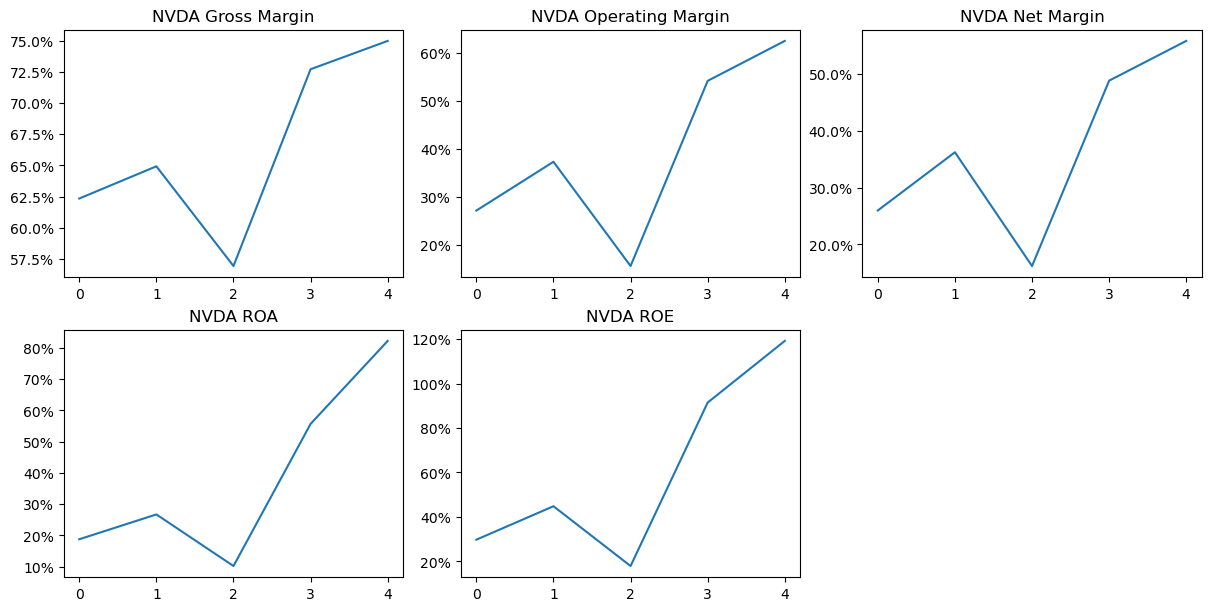

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axes = axes.flatten()

metrics_5 = [
    ("gross_margin", "Gross Margin"),
    ("operating_margin", "Operating Margin"),
    ("net_margin", "Net Margin"),
    ("roa", "ROA"),
    ("roe", "ROE"),
]

for ax, (col, title) in zip(axes, metrics_5):
    plot_metric_ax(
        ax=ax,
        df=df,
        col=col,
        title=f"NVDA {title}",
        is_percent=True
    )

for ax in axes[len(metrics_5):]:
    ax.axis("off")

plt.show()




### 2.2 Leverage & liquidity: debt-to-equity, current ratio, interest coverage

In [82]:
 # Leverage / liquidity
df["debt_total"] = df[["long_term_debt","short_term_debt"]].sum(axis=1, min_count=1)
df["debt_to_equity"] = df["debt_total"] / df["total_shareholder_equity"]
df["current_ratio"] = df["current_assets"] / df["current_liabilities"]
df["interest_coverage"] = df["operating_income"] / df["interest_expense"]
 


In [83]:
leverage_cols = [
    "debt_to_equity",
    "current_ratio",
    "interest_coverage"
]

leverage_table = (
    df.set_index("fiscal_year")[leverage_cols]
      .T
      .rename(index={
          "debt_to_equity": "Debt-to-Equity",
          "current_ratio": "Current Ratio",
          "interest_coverage": "Interest Coverage"
      })
)

leverage_table = leverage_table.round(4)

leverage_table


fiscal_year,2021,2022,2023,2024,2025
Debt-to-Equity,0.4122,0.4167,0.4956,0.2312,0.1103
Current Ratio,4.0904,6.6503,3.5156,4.1713,4.4399
Interest Coverage,24.6304,42.5466,16.1221,128.2957,329.7692


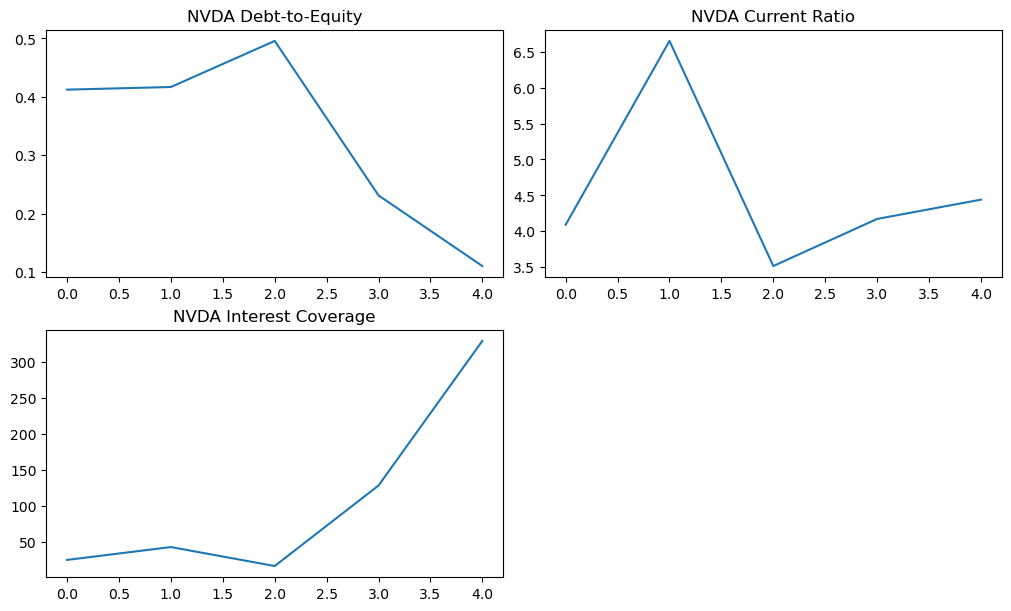

In [84]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(10, 6),
    constrained_layout=True
)

# Debt-to-Equity
plot_metric_ax(
    ax=axes[0, 0],
    df=df,
    col="debt_to_equity",
    title="NVDA Debt-to-Equity",
    is_percent=False
)

# Current Ratio
plot_metric_ax(
    ax=axes[0, 1],
    df=df,
    col="current_ratio",
    title="NVDA Current Ratio",
    is_percent=False
)

# Interest Coverage
plot_metric_ax(
    ax=axes[1, 0],
    df=df,
    col="interest_coverage",
    title="NVDA Interest Coverage",
    is_percent=False
)

fig.delaxes(axes[1, 1])

plt.show()


### 2.3 Growth: YoY for revenue / net income / FCF

In [103]:
# 1) Merge ONLY on fiscal_year (robust)
df = (
    is_df.merge(bs_df, on="fiscal_year", how="inner", suffixes=("", "_bs"))
         .merge(cf_df, on="fiscal_year", how="inner", suffixes=("", "_cf"))
         .sort_values("fiscal_year")
         .reset_index(drop=True)
)

# 2) Keep a calculation df that includes 2020
df_calc = df.copy()

# 3) YoY growth (computed on df_calc with 2020 present)
df_calc["revenue_yoy"] = df_calc["revenue"].pct_change()
df_calc["net_income_yoy"] = df_calc["net_income"].pct_change()
df_calc["fcf_yoy"] = df_calc["free_cash_flow"].pct_change()

# 4) Report df (drop 2020 only AFTER yoy is computed)
df = df_calc[df_calc["fiscal_year"] >= 2021].reset_index(drop=True)

In [104]:
growth_cols = [
    "revenue_yoy",
    "net_income_yoy",
    "fcf_yoy"
]

growth_table = (
    df.set_index("fiscal_year")[growth_cols]
      .T
      .rename(index={
          "revenue_yoy": "Revenue YoY Growth",
          "net_income_yoy": "Net Income YoY Growth",
          "fcf_yoy": "FCF YoY Growth"
      })
)

growth_table = growth_table.round(4)

growth_table


fiscal_year,2021,2022,2023,2024,2025
Revenue YoY Growth,0.5273,0.6140,0.0022,1.2585,1.1420
Net Income YoY Growth,0.5494,1.2512,-0.5521,5.8132,1.4489
FCF YoY Growth,0.0988,0.7324,-0.5317,6.0959,1.2521


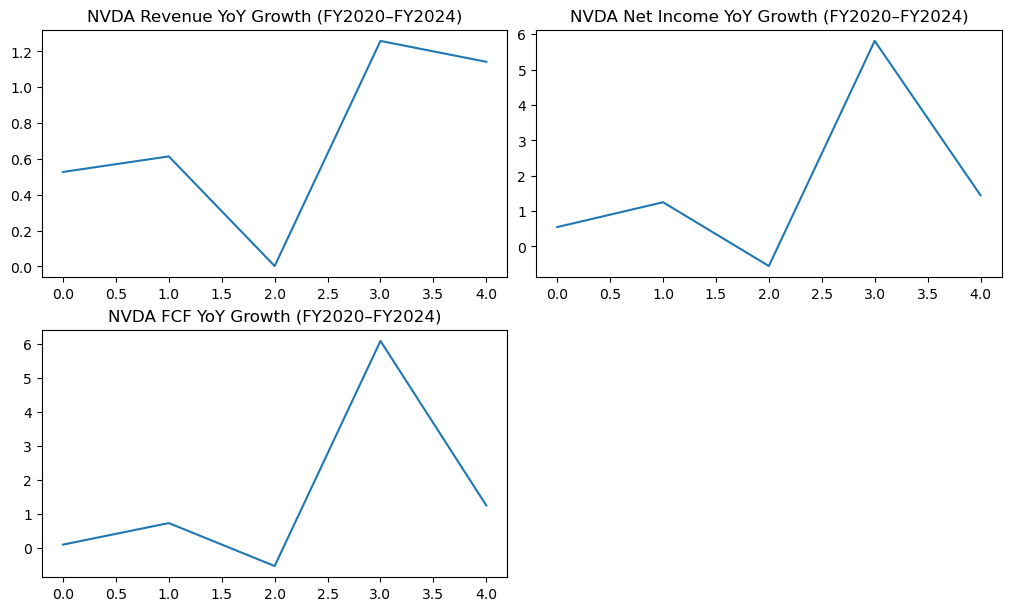

In [105]:
  fig, axes = plt.subplots(
    2, 2,
    figsize=(10, 6),
    constrained_layout=True
)

# Revenue growth
plot_metric_ax(
    ax=axes[0, 0],
    df=df,
    col="revenue_yoy",
    title="NVDA Revenue YoY Growth (FY2020–FY2024)"
)

# Net income growth
plot_metric_ax(
    ax=axes[0, 1],
    df=df,
    col="net_income_yoy",
    title="NVDA Net Income YoY Growth (FY2020–FY2024)"
)

# FCF growth
plot_metric_ax(
    ax=axes[1, 0],
    df=df,
    col="fcf_yoy",
    title="NVDA FCF YoY Growth (FY2020–FY2024)"
)

# 删掉右下角空图
fig.delaxes(axes[1, 1])

plt.show()


### Efficiency & quality: asset turnover, FCF margin, CFO-to-net-income

In [113]:
df_calc = df_test.sort_values("fiscal_year").reset_index(drop=True)

df_calc["avg_assets"] = (df_calc["total_assets"] + df_calc["total_assets"].shift(1)) / 2
df_calc["avg_equity"] = (df_calc["total_shareholder_equity"] + df_calc["total_shareholder_equity"].shift(1)) / 2

df_calc["asset_turnover"] = df_calc["revenue"] / df_calc["avg_assets"]
df_calc["fcf_margin"] = df_calc["free_cash_flow"] / df_calc["revenue"]
df_calc["cfo_to_net_income"] = df_calc["operating_cash_flow"] / df_calc["net_income"]

df = df_calc[df_calc["fiscal_year"] >= 2021].reset_index(drop=True)

In [114]:
efficiency_cols = [
    "asset_turnover",
    "fcf_margin",
    "cfo_to_net_income"
]

efficiency_table = (
    df.set_index("fiscal_year")[efficiency_cols]
      .T
      .rename(index={
          "asset_turnover": "Asset Turnover",
          "fcf_margin": "FCF Margin",
          "cfo_to_net_income": "CFO / Net Income"
      })
)

efficiency_table = efficiency_table.round(4)
efficiency_table


fiscal_year,2021,2022,2023,2024,2025
Asset Turnover,0.7233,0.7376,0.6319,1.1397,1.4718
FCF Margin,0.2815,0.3021,0.1412,0.4435,0.4663
CFO / Net Income,1.3440,0.9340,1.2914,0.9439,0.8794


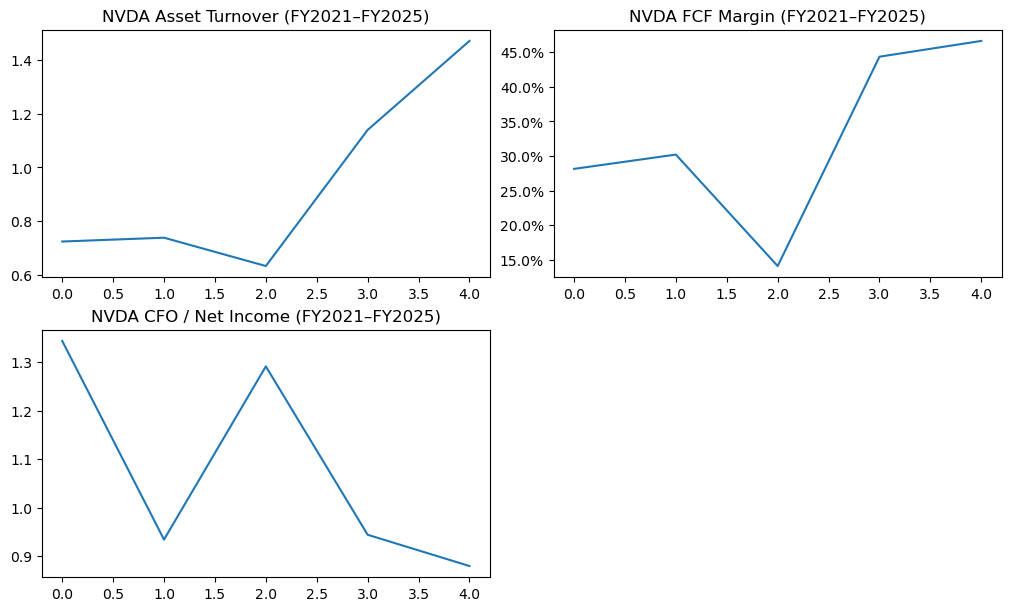

In [115]:

 fig, axes = plt.subplots(
    2, 2,
    figsize=(10, 6),
    constrained_layout=True
)

# Asset Turnover（不是百分比）
plot_metric_ax(
    ax=axes[0, 0],
    df=df,
    col="asset_turnover",
    title="NVDA Asset Turnover (FY2021–FY2025)",
    is_percent=False
)

# FCF Margin（百分比）
plot_metric_ax(
    ax=axes[0, 1],
    df=df,
    col="fcf_margin",
    title="NVDA FCF Margin (FY2021–FY2025)",
    is_percent=True
)

# CFO / Net Income（不是百分比）
plot_metric_ax(
    ax=axes[1, 0],
    df=df,
    col="cfo_to_net_income",
    title="NVDA CFO / Net Income (FY2021–FY2025)",
    is_percent=False
)

# 删除右下角空图
fig.delaxes(axes[1, 1])

plt.show()


## 3 Basic intrinsic valuation(Multiples)  

### Multiples（Relative valuation）

**Peer selection rationale for relative valuation**

ADI, QCOM, and TXN are selected as peers for NVIDIA in the relative valuation analysis because they operate within the same semiconductor industry and share asset-light, design-focused business models, making valuation multiples more comparable. All three firms exhibit high margins, strong pricing power, and stable cash flow generation, which reduces distortions arising from capital intensity and accounting differences.

Moreover, these companies represent a mature, high-quality benchmark against which NVIDIA’s significantly higher valuation multiples can be interpreted primarily as a reflection of its superior growth expectations and strategic positioning in AI, rather than structural differences in business models.

In [119]:
import os, json, time
from pathlib import Path

import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv

# =========================
# Load API key (secrets.env or system env)
# =========================
if Path("secrets.env").exists():
    load_dotenv("secrets.env")

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "").strip()
if not API_KEY:
    raise RuntimeError("Missing ALPHAVANTAGE_API_KEY. Set env var or create secrets.env")

# =========================
# Config
# =========================
TICKERS = ["NVDA", "ADI", "QCOM", "TXN"]
ASOF = pd.Timestamp("2025-01-31")  # used for selecting quarterly reports <= asof
USD_BN = 1e9

AV_BASE = "https://www.alphavantage.co/query"
RAW_DIR = Path("data_raw/alphavantage")
RAW_DIR.mkdir(parents=True, exist_ok=True)

FUNCTIONS = {
    "income_statement": "INCOME_STATEMENT",
    "cash_flow": "CASH_FLOW",
    "balance_sheet": "BALANCE_SHEET",
}

# =========================
# Helpers: Alpha Vantage fetch + cache
# =========================
def fetch_av_json(function: str, symbol: str, api_key: str, **extra_params) -> dict:
    params = {"function": function, "symbol": symbol, "apikey": api_key}
    params.update(extra_params)
    r = requests.get(AV_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    if "Error Message" in data:
        raise RuntimeError(f"Alpha Vantage error: {data['Error Message']}")
    if "Note" in data:
        raise RuntimeError(f"Alpha Vantage rate limit: {data['Note']}")
    return data

def load_or_fetch_av(symbol: str, name: str, function: str, api_key: str, **extra_params) -> dict:
    path = RAW_DIR / f"{symbol}_{name}.json"
    if path.exists():
        return json.loads(path.read_text(encoding="utf-8"))
    data = fetch_av_json(function, symbol, api_key, **extra_params)
    path.write_text(json.dumps(data, indent=2), encoding="utf-8")
    time.sleep(12)  # AV free-tier friendly
    return data

def to_float(x):
    try:
        if x is None:
            return np.nan
        return float(x)
    except Exception:
        return np.nan

def parse_date(s: str) -> pd.Timestamp:
    return pd.Timestamp(s)

def pick_last_quarters(reports: list[dict], asof: pd.Timestamp, n: int = 4) -> list[dict]:
    """Pick last n quarterly reports with fiscalDateEnding <= asof."""
    rows = []
    for r in reports:
        dt = parse_date(r["fiscalDateEnding"])
        if dt <= asof:
            rows.append((dt, r))
    rows.sort(key=lambda x: x[0])  # ascending
    if len(rows) < n:
        return []
    return [r for _, r in rows[-n:]]

def pick_latest_report(reports: list[dict], asof: pd.Timestamp) -> dict | None:
    """Pick latest single quarterly report with fiscalDateEnding <= asof."""
    rows = []
    for r in reports:
        dt = parse_date(r["fiscalDateEnding"])
        if dt <= asof:
            rows.append((dt, r))
    if not rows:
        return None
    rows.sort(key=lambda x: x[0])
    return rows[-1][1]

# =========================
# AV overview: MarketCap + SharesOutstanding
# =========================
def av_overview(symbol: str, api_key: str) -> dict:
    return load_or_fetch_av(symbol, "overview", "OVERVIEW", api_key)

def shares_outstanding_av(symbol: str, api_key: str) -> float:
    ov = av_overview(symbol, api_key)
    return to_float(ov.get("SharesOutstanding"))

def marketcap_av(symbol: str, api_key: str) -> float:
    ov = av_overview(symbol, api_key)
    return to_float(ov.get("MarketCapitalization"))

# =========================
# Extract TTM + Balance snapshot from AV
# =========================
def av_ttm_income_cash_balance(symbol: str, asof: pd.Timestamp, api_key: str):
    inc = load_or_fetch_av(symbol, "income_statement", FUNCTIONS["income_statement"], api_key)
    cf  = load_or_fetch_av(symbol, "cash_flow", FUNCTIONS["cash_flow"], api_key)
    bs  = load_or_fetch_av(symbol, "balance_sheet", FUNCTIONS["balance_sheet"], api_key)

    q_inc = inc.get("quarterlyReports", []) or []
    q_cf  = cf.get("quarterlyReports", []) or []
    q_bs  = bs.get("quarterlyReports", []) or []

    last4_inc = pick_last_quarters(q_inc, asof, n=4)
    last4_cf  = pick_last_quarters(q_cf, asof, n=4)

    # TTM income
    if len(last4_inc) < 4:
        revenue_ttm = np.nan
        net_income_ttm = np.nan
        ebit_ttm = np.nan
        last_q_used = None
    else:
        revenue_ttm = sum(to_float(r.get("totalRevenue")) for r in last4_inc)
        net_income_ttm = sum(to_float(r.get("netIncome")) for r in last4_inc)

        # EBIT: try ebit first; fallback to operatingIncome
        ebit_ttm = 0.0
        miss = 0
        for r in last4_inc:
            v = to_float(r.get("ebit"))
            if pd.isna(v):
                v = to_float(r.get("operatingIncome"))
            if pd.isna(v):
                miss += 1
            else:
                ebit_ttm += v
        if miss > 0:
            ebit_ttm = np.nan

        last_q_used = last4_inc[-1]["fiscalDateEnding"]

    # D&A TTM
    if len(last4_cf) < 4:
        da_ttm = np.nan
        last_q_cf_used = None
    else:
        da_keys = ["depreciationDepletionAndAmortization", "depreciationAndAmortization", "depreciation"]
        da_vals = []
        for r in last4_cf:
            v = np.nan
            for k in da_keys:
                v = to_float(r.get(k))
                if pd.notna(v):
                    break
            da_vals.append(v)

        da_ttm = np.nan if any(pd.isna(v) for v in da_vals) else float(np.sum(da_vals))
        last_q_cf_used = last4_cf[-1]["fiscalDateEnding"]

    ebitda_ttm = (ebit_ttm + da_ttm) if (pd.notna(ebit_ttm) and pd.notna(da_ttm)) else np.nan

    # Balance sheet snapshot (latest quarter <= asof)
    bs_last = pick_latest_report(q_bs, asof)
    if bs_last is None:
        cash = np.nan
        total_debt = np.nan
        bs_used = None
    else:
        bs_used = bs_last["fiscalDateEnding"]
        cash = to_float(bs_last.get("cashAndCashEquivalentsAtCarryingValue"))

        debt_lt = to_float(bs_last.get("longTermDebt"))
        debt_st = to_float(bs_last.get("shortLongTermDebtTotal"))  # ST debt + current portion
        debt_lt = 0.0 if pd.isna(debt_lt) else debt_lt
        debt_st = 0.0 if pd.isna(debt_st) else debt_st
        total_debt = debt_lt + debt_st

    return {
        "Revenue_TTM": revenue_ttm,
        "NetIncome_TTM": net_income_ttm,
        "EBITDA_TTM": ebitda_ttm,
        "Cash": cash,
        "TotalDebt": total_debt,
        "TTM_Income_LastQuarterUsed": last_q_used,
        "TTM_CF_LastQuarterUsed": last_q_cf_used,
        "Balance_LastQuarterUsed": bs_used,
    }

# =========================
# Build final table (items x tickers)
# =========================
def extract_peer_row(symbol: str, asof: pd.Timestamp, api_key: str) -> pd.Series:
    av = av_ttm_income_cash_balance(symbol, asof, api_key)

    # Use AV Overview for MarketCap + SharesOutstanding (no daily price)
    mkt = marketcap_av(symbol, api_key)         # USD
    sh  = shares_outstanding_av(symbol, api_key) # shares

    # Optional: implied price = MarketCap / SharesOutstanding (if both available)
    implied_px = (mkt / sh) if (pd.notna(mkt) and pd.notna(sh) and sh != 0) else np.nan

    s = pd.Series(
        {
            "ImpliedPrice (USD/share)": implied_px,  # derived from OV market cap & shares
            "NetIncome_TTM (USD bn)": av["NetIncome_TTM"]/USD_BN if pd.notna(av["NetIncome_TTM"]) else np.nan,
            "SharesOutstanding (bn shares)": sh/USD_BN if pd.notna(sh) else np.nan,
            "MarketCap (USD bn)": mkt/USD_BN if pd.notna(mkt) else np.nan,
            "TotalDebt (USD bn)": av["TotalDebt"]/USD_BN if pd.notna(av["TotalDebt"]) else np.nan,
            "Cash (USD bn)": av["Cash"]/USD_BN if pd.notna(av["Cash"]) else np.nan,
            "EBITDA_TTM (USD bn)": av["EBITDA_TTM"]/USD_BN if pd.notna(av["EBITDA_TTM"]) else np.nan,
            "Revenue_TTM (USD bn)": av["Revenue_TTM"]/USD_BN if pd.notna(av["Revenue_TTM"]) else np.nan,
        },
        name=symbol,
    )
    return s

table = pd.concat([extract_peer_row(sym, ASOF, API_KEY) for sym in TICKERS], axis=1)

row_order = [
    "ImpliedPrice (USD/share)",
    "NetIncome_TTM (USD bn)",
    "SharesOutstanding (bn shares)",
    "MarketCap (USD bn)",
    "TotalDebt (USD bn)",
    "Cash (USD bn)",
    "EBITDA_TTM (USD bn)",
    "Revenue_TTM (USD bn)",
]
table = table.loc[row_order]

display(table)



,NVDA,ADI,QCOM,TXN
ImpliedPrice (USD/share),178.377726,295.670077,157.538035,194.520003
NetIncome_TTM (USD bn),72.880000,1.563862,10.555000,4.799000
SharesOutstanding (bn shares),24.305000,0.489654,1.071000,0.908623
MarketCap (USD bn),4335.470641,144.776036,168.723235,176.745349
TotalDebt (USD bn),18.733000,14.185370,27.789000,26.442000
Cash (USD bn),8.589000,2.349994,8.713000,3.200000
EBITDA_TTM (USD bn),86.137000,4.114516,12.915000,7.541000
Revenue_TTM (USD bn),130.497000,9.337627,40.695000,15.641000


In [180]:
table_use = table  
ev = (
    table_use.loc["MarketCap (USD bn)"]
    + table_use.loc["TotalDebt (USD bn)"]
    - table_use.loc["Cash (USD bn)"]
)

ni = table_use.loc["NetIncome_TTM (USD bn)"].replace(0, np.nan)
ebitda = table_use.loc["EBITDA_TTM (USD bn)"].replace(0, np.nan)
sales = table_use.loc["Revenue_TTM (USD bn)"].replace(0, np.nan)

multiples_ttm = pd.DataFrame({
    "P/E (TTM)": table_use.loc["MarketCap (USD bn)"] / ni,
    "EV/EBITDA (TTM)": ev / ebitda,
    "EV/Sales (TTM)": ev / sales,
}).round(2)

display(multiples_ttm)



,P/E (TTM),EV/EBITDA (TTM),EV/Sales (TTM)
NVDA,59.49,50.45,33.30
ADI,92.58,38.06,16.77
QCOM,15.99,14.54,4.61
TXN,36.83,26.52,12.79


In [193]:
import pandas as pd
import numpy as np

tickers = ["NVDA", "ADI", "QCOM", "TXN"]

if set(tickers).issubset(set(multiples_ttm.columns)):
    mult = multiples_ttm.copy()

elif set(tickers).issubset(set(multiples_ttm.index)):
    mult = multiples_ttm.T.copy()

else:
    raise RuntimeError(
        "Cannot find tickers in multiples_ttm either in columns or index.\n"
        f"columns={list(multiples_ttm.columns)}\n"
        f"index={list(multiples_ttm.index)}"
    )

peer_cols = [c for c in mult.columns if c in tickers]
peer_mult = mult[peer_cols].copy()

peers_only = [c for c in peer_cols if c != "NVDA"]
if len(peers_only) == 0:
    raise RuntimeError("Peers list is empty (need ADI/QCOM/TXN columns).")

peer_mult["Peer Avg (ex-NVDA)"] = peer_mult[peers_only].mean(axis=1, skipna=True)
peer_mult["Peer Median (ex-NVDA)"] = peer_mult[peers_only].median(axis=1, skipna=True)

peer_mult["NVDA vs Peer Avg"] = peer_mult["NVDA"] / peer_mult["Peer Avg (ex-NVDA)"] - 1

peer_compare_tbl = peer_mult.round(2)
display(peer_compare_tbl)

multiples_text = "### Multiples peer comparison\n" + peer_compare_tbl.to_markdown()


,NVDA,ADI,QCOM,TXN,Peer Avg (ex-NVDA),Peer Median (ex-NVDA),NVDA vs Peer Avg
P/E (TTM),59.49,92.58,15.99,36.83,48.47,36.83,0.23
EV/EBITDA (TTM),50.45,38.06,14.54,26.52,26.37,26.52,0.91
EV/Sales (TTM),33.30,16.77,4.61,12.79,11.39,12.79,1.92


In [121]:
multiples_ttm.loc["Semiconductor Avg"] = [37.29, 42.70, 15.70]
multiples_ttm.loc["Market Avg (S&P500)"] = [27.66, 23.95, 3.97]

display(multiples_ttm)

,P/E (TTM),EV/EBITDA (TTM),EV/Sales (TTM)
NVDA,59.49,50.45,33.30
ADI,92.58,38.06,16.77
QCOM,15.99,14.54,4.61
TXN,36.83,26.52,12.79
Semiconductor Avg,37.29,42.70,15.70
Market Avg (S&P500),27.66,23.95,3.97


Market and industry valuation benchmarks are obtained from Professor Aswath Damodaran’s valuation database (NYU Stern School of Business):
https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/vebitda.html

According to the latest data, the U.S. total market averages are P/E = 27.66×, EV/Sales = 3.97×, and EV/EBITDA = 23.95×. In comparison, the semiconductor industry averages are substantially higher, with P/E = 37.29×, EV/Sales = 15.70×, and EV/EBITDA = 42.70×. These benchmarks are used as reference multiples for relative valuation analysis.

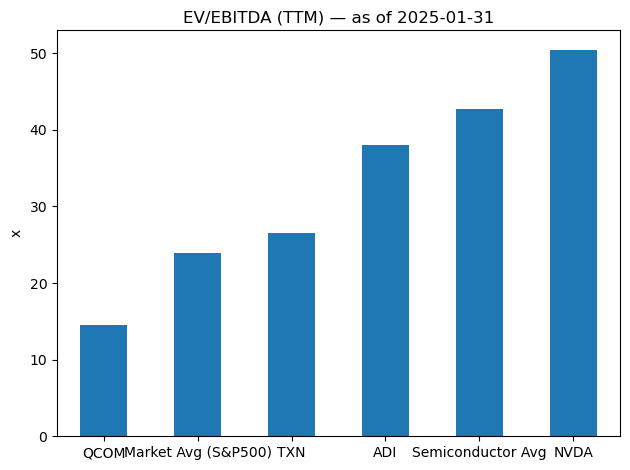

In [122]:
import matplotlib.pyplot as plt
 
ax = multiples_ttm["EV/EBITDA (TTM)"].sort_values().plot(kind="bar", title="EV/EBITDA (TTM) — as of 2025-01-31", rot=0)
ax.set_ylabel("x")
plt.tight_layout()
plt.show()



NVIDIA trades at a clear premium on EV/EBITDA, standing materially above both its closest peers (ADI, TXN, QCOM) and the broader market benchmark. While the semiconductor industry average appears even higher, NVIDIA remains firmly positioned in the upper valuation range, reflecting strong market confidence in its AI-driven growth, superior margins, and operating leverage. Overall, the elevated multiple suggests that NVIDIA is priced as a structurally differentiated growth platform rather than a traditional cyclical semiconductor manufacturer.

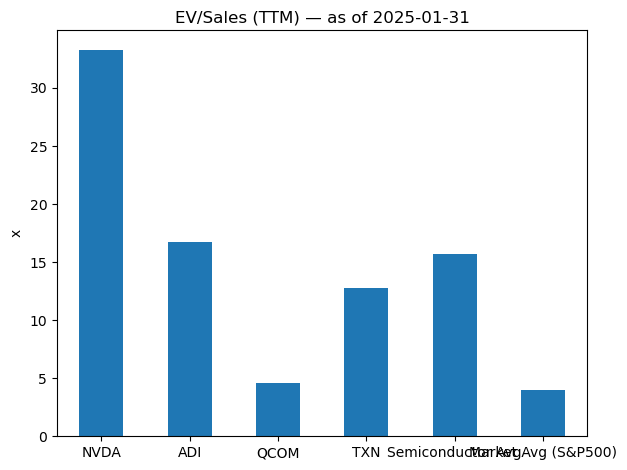

In [124]:
import matplotlib.pyplot as plt
 
order = ["NVDA", "ADI", "QCOM", "TXN","Semiconductor Avg","Market Avg (S&P500)"]

ax = multiples_ttm.loc[order, "EV/Sales (TTM)"].plot(
    kind="bar",
    title="EV/Sales (TTM) — as of 2025-01-31",
    rot=0
)
ax.set_ylabel("x")
plt.tight_layout()
plt.show()



NVIDIA trades at by far the highest EV/Sales multiple among peers and stands well above both the semiconductor industry average and the broader market benchmark. This indicates that the market prices NVIDIA not merely as a semiconductor manufacturer, but as a structurally superior growth platform with exceptional revenue scalability and pricing power driven by AI demand.

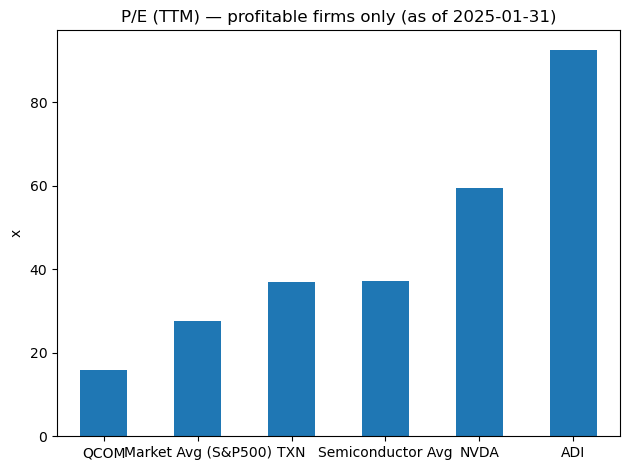

In [125]:
import matplotlib.pyplot as plt
import numpy as np

pe = multiples_ttm["P/E (TTM)"].copy()
# keep only meaningful P/E (positive and finite)
pe = pe.replace([np.inf, -np.inf], np.nan)
pe = pe[pe > 0].dropna()

ax = pe.sort_values().plot(kind="bar", title="P/E (TTM) — profitable firms only (as of 2025-01-31)", rot=0)
ax.set_ylabel("x")
plt.tight_layout()
plt.show()


NVIDIA trades at a P/E multiple above both the semiconductor industry average and the broader market benchmark, indicating that investors are willing to pay a premium for its superior earnings growth and AI-driven profitability. Although ADI commands an even higher P/E due to its more mature and stable earnings base, NVIDIA remains clearly positioned in the upper valuation tier of the sector.

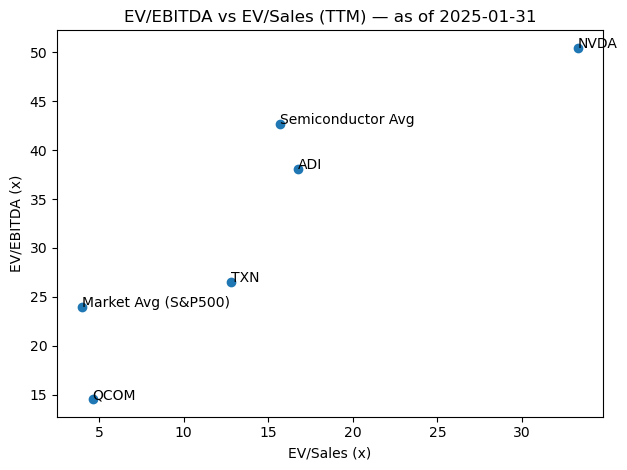

In [126]:
import matplotlib.pyplot as plt

x = multiples_ttm["EV/Sales (TTM)"]
y = multiples_ttm["EV/EBITDA (TTM)"]

plt.figure()
plt.scatter(x, y)

for name in multiples_ttm.index:
    plt.annotate(name, (x.loc[name], y.loc[name]))

plt.title("EV/EBITDA vs EV/Sales (TTM) — as of 2025-01-31")
plt.xlabel("EV/Sales (x)")
plt.ylabel("EV/EBITDA (x)")
plt.tight_layout()
plt.show()


NVIDIA is positioned in the upper-right corner of the valuation space, exhibiting both the highest EV/Sales and one of the highest EV/EBITDA multiples among peers. This dual-premium positioning indicates that the market prices NVIDIA not only for superior growth but also for exceptional profitability, distinguishing it structurally from traditional semiconductor peers.

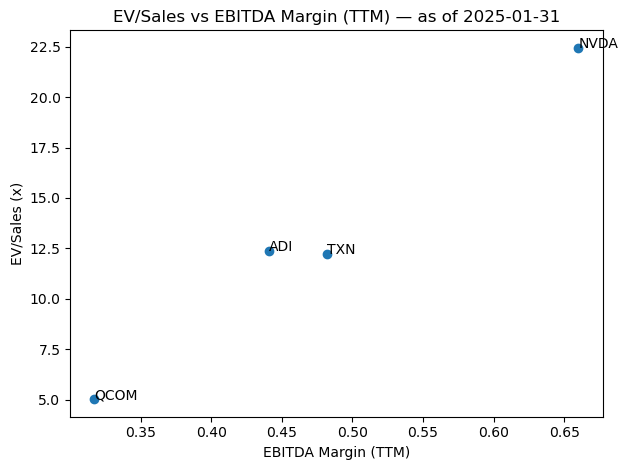

In [34]:
import matplotlib.pyplot as plt

# EBITDA margin (只在 table_display 有的公司里)
ebitda_margin = (
    table_display.loc["EBITDA_TTM (USD bn)"] / table_display.loc["Revenue_TTM (USD bn)"]
)

# 只取“同时存在”的行（避免 Semiconductor Avg / Market Avg 造成 KeyError）
common = ebitda_margin.index.intersection(multiples_ttm.index)

x = ebitda_margin.loc[common]
y = multiples_ttm.loc[common, "EV/Sales (TTM)"]

plt.figure()
plt.scatter(x, y)

for name in common:
    plt.annotate(name, (x.loc[name], y.loc[name]))

plt.title("EV/Sales vs EBITDA Margin (TTM) — as of 2025-01-31")
plt.xlabel("EBITDA Margin (TTM)")
plt.ylabel("EV/Sales (x)")
plt.tight_layout()
plt.show()



A positive relationship between EBITDA margin and EV/Sales is evident across firms. NVDA combines the highest margin with the highest revenue multiple, supporting the view that superior profitability and growth drive its premium valuation. ADI and TXN show high margins with moderate EV/Sales, while QCOM’s lower margin corresponds to a lower valuation multiple. This pattern reinforces the economic intuition behind the relative valuation results.

## 4 Basic intrinsic valuation: Simple FCFF DCF  

MarketCap / Shares / Beta / 52W

In [129]:
import os
import requests
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

if Path("secrets.env").exists():
    load_dotenv("secrets.env")

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "").strip()
if not API_KEY:
    raise RuntimeError("Missing ALPHAVANTAGE_API_KEY")

AV_BASE = "https://www.alphavantage.co/query"

def av_get(function: str, symbol: str) -> dict:
    params = {
        "function": function,
        "symbol": symbol,
        "apikey": API_KEY
    }
    r = requests.get(AV_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    if "Error Message" in data:
        raise RuntimeError(data["Error Message"])
    if "Note" in data:
        raise RuntimeError(data["Note"])
    return data

symbol = "NVDA"
ov = av_get("OVERVIEW", symbol)

def to_float(x):
    try:
        return float(x)
    except Exception:
        return pd.NA

overview_tbl = pd.DataFrame([{
    "MarketCap (USD bn)": to_float(ov.get("MarketCapitalization")) / 1e9,
    "Shares Outstanding (bn)": to_float(ov.get("SharesOutstanding")) / 1e9,
    "Beta": to_float(ov.get("Beta")),
    "52W High (USD)": to_float(ov.get("52WeekHigh")),
    "52W Low (USD)": to_float(ov.get("52WeekLow")),
}])

display(overview_tbl)


,MarketCap (USD bn),Shares Outstanding (bn),Beta,52W High (USD),52W Low (USD)
0,4335.470641,24.305,2.314,212.18,86.6


Key ratio assumption table

In [134]:
base_year = 2025

rev0 = is_view.loc["revenue", base_year]
ebit0 = is_view.loc["operating_income", base_year]

ebit_margin = ebit0 / rev0

tax_rate = (
    is_view.loc["income_tax_expense"] /
    is_view.loc["income_before_tax"]
).loc[2023:2025].median()          # 用最近3年稳健税率
tax_rate = float(np.clip(tax_rate, 0.05, 0.25))

da_ratio = (
    cf_view.loc["depreciation_and_amortization"] /
    is_view.loc["revenue"]
).loc[2023:2025].median()

capex_ratio = (
    cf_view.loc["capex_outflow"] /
    is_view.loc["revenue"]
).loc[2023:2025].median()

operating_nwc = (
    bs_view.loc["current_assets"]
    - bs_view.loc["cash_and_cash_equivalents"]
    - bs_view.loc["short_term_investments"]
    - (bs_view.loc["current_liabilities"] - bs_view.loc["short_term_debt"])
)
nwc_ratio = (operating_nwc / is_view.loc["revenue"]).loc[2023:2025].median()


D = bs_view.loc["long_term_debt", base_year] + bs_view.loc["short_term_debt", base_year]

E = overview_tbl.loc[0, "MarketCap (USD bn)"]


In [135]:
assumption_view = pd.DataFrame({
    2025: [
        rev0,
        ebit_margin,
        tax_rate,
        da_ratio,
        capex_ratio,
        nwc_ratio,
        D,
        E
    ]
}, index=[
    "Base Revenue",
    "EBIT Margin",
    "Tax Rate",
    "D&A / Revenue",
    "CapEx / Revenue",
    "NWC / Revenue",
    "Debt (D)",
    "Equity (E)"
])

assumption_view


,2025
Base Revenue,130.497000
EBIT Margin,0.624175
Tax Rate,0.119995
D&A / Revenue,0.024753
CapEx / Revenue,0.024798
NWC / Revenue,0.151144
Debt (D),8.751000
Equity (E),4335.470641


growth rate

In [137]:
base_year = 2025
start_year = 2021
horizon = 5   

rev_start = float(is_view.loc["revenue", start_year])
rev_base  = float(is_view.loc["revenue", base_year])

n = base_year - start_year
rev_cagr = (rev_base / rev_start) ** (1/n) - 1

rev_cagr

0.6725675679020933

In [138]:
years_fwd = list(range(base_year + 1, base_year + 1 + horizon))

revenue_forecast = pd.Series(
    [rev_base * ((1 + rev_cagr) ** i) for i in range(1, horizon + 1)],
    index=years_fwd,
    name="Revenue_Forecast (USD bn)"
)

revenue_forecast

2026     218.265050
2027     365.063044
2028     610.592607
2029    1021.257392
2030    1708.121992
Name: Revenue_Forecast (USD bn), dtype: float64

In [139]:
revenue_hist = is_view.loc["revenue", start_year:base_year].astype(float)
revenue_all = pd.concat([revenue_hist, revenue_forecast])

revenue_all.to_frame()

,0
2021,16.675000
2022,26.914000
2023,26.974000
2024,60.922000
2025,130.497000
2026,218.265050
2027,365.063044
2028,610.592607
2029,1021.257392
2030,1708.121992


In [140]:
assumption_view.loc["Revenue CAGR (from {} to {})".format(start_year, base_year), base_year] = float(rev_cagr)
assumption_view

,2025
Base Revenue,130.497000
EBIT Margin,0.624175
Tax Rate,0.119995
D&A / Revenue,0.024753
CapEx / Revenue,0.024798
NWC / Revenue,0.151144
Debt (D),8.751000
Equity (E),4335.470641
Revenue CAGR (from 2021 to 2025),0.672568


FCF

In [170]:
import pandas as pd
import numpy as np

# revenue_forecast: pd.Series, index = [2026..2030], values in USD bn
# base_year = 2025

ebit_f = revenue_forecast * ebit_margin
nopat_f = ebit_f * (1 - tax_rate)

da_f = revenue_forecast * da_ratio
capex_f = revenue_forecast * capex_ratio   

nwc_level_f = revenue_forecast * nwc_ratio

nwc_base = float(
    (
        bs_view.loc["current_assets", base_year]
        - bs_view.loc["cash_and_cash_equivalents", base_year]
        - bs_view.loc["short_term_investments", base_year]
        - (bs_view.loc["current_liabilities", base_year] - bs_view.loc["short_term_debt", base_year])
    )
)

delta_nwc_f = nwc_level_f - pd.Series(
    [nwc_base] + list(nwc_level_f.values[:-1]),
    index=revenue_forecast.index
)

# FCFF = NOPAT + D&A - CapEx - ΔNWC
fcff_f = nopat_f + da_f - capex_f - delta_nwc_f

fcff_forecast_tbl = pd.DataFrame({
    "Revenue": revenue_forecast,
    "EBIT": ebit_f,
    "NOPAT": nopat_f,
    "D&A": da_f,
    "CapEx": capex_f,
    "NWC_Level": nwc_level_f,
    "ΔNWC": delta_nwc_f,
    "FCFF": fcff_f,
}).round(4)

fcff_forecast_tbl



,Revenue,EBIT,NOPAT,D&A,CapEx,NWC_Level,ΔNWC,FCFF
2026,218.2650,136.2356,119.8880,5.4027,5.4124,32.9895,13.8325,106.0458
2027,365.0630,227.8633,200.5208,9.0364,9.0527,55.1771,22.1876,178.3169
2028,610.5926,381.1168,335.3846,15.1140,15.1412,92.2875,37.1103,298.2471
2029,1021.2574,637.4436,560.9534,25.2791,25.3246,154.3570,62.0696,498.8383
2030,1708.1220,1066.1675,938.2324,42.2811,42.3572,258.1725,103.8155,834.3408


计算WACC

In [166]:
import os, json
import requests
import pandas as pd
import numpy as np
from pathlib import Path

# =========================
# Config
# =========================
AV_BASE = "https://www.alphavantage.co/query"
RAW_DIR = Path("data_raw/alphavantage")
RAW_DIR.mkdir(parents=True, exist_ok=True)

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "").strip()
if not API_KEY:
    raise RuntimeError("Missing ALPHAVANTAGE_API_KEY (set env var or secrets.env)")

# =========================
# Alpha Vantage helpers (cache-first)
# =========================
def av_get(function, symbol=None, **kwargs):
    """
    Cache-first Alpha Vantage getter.
    - If cache exists and looks like real data -> return cache
    - Otherwise try live request, cache response, then validate
    """
    # cache file name
    sym = symbol if symbol is not None else "GLOBAL"
    cache_path = RAW_DIR / f"{sym}_{function}.json"

    # 1) cache first (avoid rate limit)
    if cache_path.exists() and cache_path.stat().st_size > 200:
        try:
            cached = json.loads(cache_path.read_text(encoding="utf-8"))
            # return cache only if it is not a rate-limit/info/error payload
            if (
                isinstance(cached, dict)
                and "Error Message" not in cached
                and "Note" not in cached
                and "Information" not in cached
            ):
                return cached
        except Exception:
            pass  # corrupted cache -> fall through to live

    # 2) live request
    params = {"function": function, "apikey": API_KEY}
    if symbol is not None:
        params["symbol"] = symbol
    params.update(kwargs)

    r = requests.get(AV_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()

    # 3) always write response to cache (even if it's an error/info; helps debugging)
    try:
        cache_path.write_text(json.dumps(data, indent=2), encoding="utf-8")
    except Exception:
        pass

    # 4) validate response
    if "Error Message" in data:
        raise RuntimeError(data["Error Message"])
    if "Note" in data:
        raise RuntimeError(data["Note"])
    if "Information" in data:
        raise RuntimeError(data["Information"])

    return data

def beta_from_av(symbol: str) -> float:
    ov = av_get("OVERVIEW", symbol=symbol)
    return float(ov.get("Beta", np.nan))

def marketcap_from_av(symbol: str) -> float:
    ov = av_get("OVERVIEW", symbol=symbol)
    return float(ov.get("MarketCapitalization", np.nan)) / 1e9  # USD bn

# =========================
# Risk-free (FRED 10Y)
# =========================
def risk_free_rate_us() -> float:
    url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=DGS10"
    df = pd.read_csv(url)
    df["DGS10"] = pd.to_numeric(df["DGS10"], errors="coerce")
    rf = df["DGS10"].dropna().iloc[-1]
    return float(rf) / 100.0

# =========================
# ERP (Damodaran) - multi-source + cache
# =========================
def _download(url: str, cache_path: Path) -> bool:
    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        r = requests.get(url, headers=headers, timeout=60, allow_redirects=True)
        r.raise_for_status()
        cache_path.write_bytes(r.content)
        return True
    except Exception:
        return False

def _erp_from_ctryprem_xlsx(xlsx_path: Path) -> float:
    xls = pd.read_excel(xlsx_path, sheet_name=0)
    cols = {str(c).strip().lower(): c for c in xls.columns}

    col_found = None
    for low, orig in cols.items():
        if ("mature" in low) and ("premium" in low):
            col_found = orig
            break
    if col_found is None:
        raise RuntimeError(f"Cannot find Mature Market premium column. Columns: {list(xls.columns)}")

    ser = pd.to_numeric(xls[col_found], errors="coerce").dropna()
    if ser.empty:
        raise RuntimeError("Mature Market premium column has no numeric values.")

    return float(ser.median()) / 100.0  # percent -> decimal

def _erp_from_histimpl_xls(xls_path: Path) -> float:
    xls = pd.read_excel(xls_path, sheet_name=0)

    col = None
    for c in xls.columns:
        low = str(c).lower()
        if "erp" in low:
            col = c
            break
        if "implied" in low and "premium" in low:
            col = c
            break
    if col is None:
        raise RuntimeError(f"Cannot find ERP column in histimpl. Columns: {list(xls.columns)}")

    ser = pd.to_numeric(xls[col], errors="coerce").dropna()
    if ser.empty:
        raise RuntimeError("ERP column has no numeric values.")

    return float(ser.iloc[-1]) / 100.0

def erp_us_auto() -> tuple[float, str]:
    ctry_cache = RAW_DIR / "damodaran_ctryprem.xlsx"
    hist_cache = RAW_DIR / "damodaran_histimpl.xls"

    urls = [
        ("ctryprem", "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.xlsx", ctry_cache),
        ("histimpl", "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histimpl.xls", hist_cache),
    ]

    for tag, url, path in urls:
        ok = _download(url, path)
        if ok:
            try:
                if tag == "ctryprem":
                    return _erp_from_ctryprem_xlsx(path), "Damodaran ctryprem.xlsx (downloaded)"
                else:
                    return _erp_from_histimpl_xls(path), "Damodaran histimpl.xls (downloaded)"
            except Exception:
                pass

    if ctry_cache.exists() and ctry_cache.stat().st_size > 10_000:
        try:
            return _erp_from_ctryprem_xlsx(ctry_cache), "Damodaran ctryprem.xlsx (cached)"
        except Exception:
            pass
    if hist_cache.exists() and hist_cache.stat().st_size > 5_000:
        try:
            return _erp_from_histimpl_xls(hist_cache), "Damodaran histimpl.xls (cached)"
        except Exception:
            pass

    return 0.05, "Fallback default 5% (all external ERP fetch failed)"

# =========================
# Cost of debt from statements (no manual)
# =========================
def cost_of_debt_from_statements(is_view, bs_view, year: int) -> float:
    interest = float(is_view.loc["interest_expense", year])
    debt = float(bs_view.loc["long_term_debt", year] + bs_view.loc["short_term_debt", year])

    interest = abs(interest)
    if debt <= 0:
        return np.nan
    return interest / debt

# =========================
# WACC
# =========================
def compute_wacc(symbol: str, base_year: int, is_view, bs_view, tax_rate: float):
    rf = risk_free_rate_us()
    beta = beta_from_av(symbol)
    erp, erp_source = erp_us_auto()
    re = rf + beta * erp

    rd = cost_of_debt_from_statements(is_view, bs_view, base_year)

    D = float(bs_view.loc["long_term_debt", base_year] + bs_view.loc["short_term_debt", base_year])

    # IMPORTANT: Equity uses your multiples table MarketCap (stable, consistent with ASOF)
    E = float(table.loc["MarketCap (USD bn)", symbol])

    V = D + E
    wE = E / V if V > 0 else np.nan
    wD = D / V if V > 0 else np.nan

    wacc = wE * re + wD * rd * (1 - tax_rate)

    return {
        "Risk-free rate (10Y)": rf,
        "Beta": beta,
        "ERP": erp,
        "ERP source": erp_source,
        "Cost of equity (Re)": re,
        "Cost of debt (Rd)": rd,
        "Tax rate": float(tax_rate),
        "Debt (D, USD bn)": D,
        "Equity (E, USD bn)": E,
        "wE": wE,
        "wD": wD,
        "WACC": wacc
    }

# =========================
# Run
# =========================
base_year = 2025
wacc_out = compute_wacc(SYMBOL, base_year, is_view, bs_view, tax_rate)
wacc_tbl = pd.DataFrame(wacc_out, index=["value"]).T
wacc_tbl


,value
Risk-free rate (10Y),0.043
Beta,2.314
ERP,0.05
ERP source,Fallback default 5% (all external ERP fetch fa...
Cost of equity (Re),0.1587
Cost of debt (Rd),0.028225
Tax rate,0.119995
"Debt (D, USD bn)",8.751
"Equity (E, USD bn)",4335.470641
wE,0.997986


Terminal Value + 折现 → EV

In [173]:
fcffs = fcff_f.astype(float).to_numpy()
wacc = float(wacc_out["WACC"])

In [174]:
# ========= Terminal Value + Discounting =========

g = 0.045   # terminal growth (long-run FCFF growth)

# 1) Terminal Value at end of Year 5 (Gordon Growth Model)
tv = fcffs[-1] * (1 + g) / (wacc - g)

# 2) Discount all FCFFs and TV back to valuation date
pv_fcff = sum([fcffs[i] / (1 + wacc) ** (i + 1) for i in range(5)])
pv_tv   = tv / (1 + wacc) ** 5

# 3) Enterprise Value
EV = pv_fcff + pv_tv

EV


np.float64(4777.731650794238)

Intrinsic value

In [178]:
def shares_outstanding_bn_from_av(symbol: str) -> float:
    ov = av_get("OVERVIEW", symbol=symbol)  # cache-first
    sh = ov.get("SharesOutstanding", None)
    try:
        return float(sh) / 1e9  # bn shares
    except Exception:
        return np.nan

shares_bn = shares_outstanding_bn_from_av(SYMBOL)

debt = float(D)  # USD bn
cash = float(bs_view.loc["cash_and_cash_equivalents", base_year])  # USD bn
equity = EV - debt + cash  # USD bn

intrinsic_price = equity / shares_bn  # USD/share
intrinsic_price



np.float64(196.5673586008738)

In [203]:
def market_price_realtime_av(symbol: str) -> float:
    """
    Get near-real-time price from Alpha Vantage GLOBAL_QUOTE.
    """
    data = av_get("GLOBAL_QUOTE", symbol=symbol)
    q = data.get("Global Quote", {}) or {}
    px = q.get("05. price", None)
    try:
        return float(px)
    except Exception:
        return np.nan


market_price_now = market_price_realtime_av(SYMBOL)

compare_now = pd.DataFrame({
    "Market price NOW (USD/share)": [market_price_now],
    "Intrinsic value (USD/share)": [float(intrinsic_price)],
})
compare_now["Upside / Downside"] = (
    compare_now["Intrinsic value (USD/share)"] / compare_now["Market price NOW (USD/share)"] - 1
)

compare_now.round(4)


,Market price NOW (USD/share),Intrinsic value (USD/share),Upside / Downside
0,183.32,196.5674,0.0723


## 5 LLM-generated 1–2 page investment memo citing data sources.
 


In [188]:
import textwrap

def df_to_md(df, title, max_rows=50):
    if df is None:
        return f"### {title}\n(N/A)\n"
    d = df.copy()
    # 防止太长
    if d.shape[0] > max_rows:
        d = d.head(max_rows)
    return f"### {title}\n{d.to_markdown()}\n"

# 你可能有的增长表名字不同：这里做个兼容
growth_tbl = None
for cand in ["growth_table", "growth_view", "growth_metrics", "growth_rates"]:
    if cand in globals():
        growth_tbl = globals()[cand]
        break

inputs_text = "\n".join([
    df_to_md(metrics_table, "Profitability (Gross/Op/Net Margin, ROA, ROE)"),
    df_to_md(leverage_table, "Leverage & Liquidity (Debt-to-Equity, Current Ratio, Interest Coverage)"),
    df_to_md(efficiency_table, "Efficiency / Cash Quality (Asset Turnover, FCF Margin, CFO/Net Income)"),
    df_to_md(growth_tbl, "Growth (YoY Revenue / Net Income / FCF)"),
    df_to_md(multiples_ttm, "Multiples (TTM P/E, EV/EBITDA, EV/Sales)"),
    df_to_md(wacc_tbl, "WACC Breakdown (rf, beta, ERP, Re, Rd, weights, WACC)"),
    df_to_md(fcff_forecast_tbl, "FCFF Forecast (Revenue-driven, 5Y explicit forecast)"),
])

# 一些关键标量（你已经算出来的）
summary_text = textwrap.dedent(f"""
Company: {SYMBOL}
Valuation: FCFF-based DCF + Multiples
Intrinsic value (USD/share): {float(intrinsic_price):.2f}
Market price (USD/share): {float(market_price_now):.2f}
Implied upside/downside: {float(intrinsic_price/market_price_now - 1):.2%}

Data sources used in analysis:
- Alpha Vantage: financial statements (income/balance/cashflow), company overview, prices/quotes (via your cached av_get)
- FRED: US 10Y Treasury yield (risk-free rate)
- Damodaran: ERP (with cached download; fallback default if blocked)
""").strip()


In [197]:
dcf_inputs_text = f"""
Base year: {base_year}

--- Key DCF assumptions ---
Terminal growth rate (g): {g:.4f}
WACC: {float(wacc_tbl.loc["WACC","value"]):.4f}

--- FCFF forecast (USD bn) ---
{fcff_forecast_tbl[["FCFF"]].to_markdown()}

--- Valuation bridge ---
Enterprise Value (EV, USD bn): {EV:.2f}
Net Debt = Debt - Cash (USD bn): {(debt - cash):.2f}
Equity Value (USD bn): {equity:.2f}

shares_bn = float(overview_tbl.loc[0, "Shares Outstanding (bn)"])
Intrinsic Value (USD/share): {intrinsic_price:.2f}
"""


In [198]:
def col_trend_summary(table, row_name, label, years=None, pct=True):
    # table: 你的 metrics_table / leverage_table / efficiency_table
    s = table.loc[row_name].dropna()
    if years is not None:
        s = s.loc[[y for y in years if y in s.index]]
    if s.empty:
        return f"- {label}: N/A"
    y0, y1 = int(s.index[0]), int(s.index[-1])
    v0, v1 = float(s.iloc[0]), float(s.iloc[-1])
    vmin, ymin = float(s.min()), int(s.idxmin())
    vmax, ymax = float(s.max()), int(s.idxmax())
    if pct:
        fmt = lambda x: f"{x:.2%}"
    else:
        fmt = lambda x: f"{x:.2f}"
    return (
        f"- {label}: {fmt(v0)} ({y0}) → {fmt(v1)} ({y1}); "
        f"min {fmt(vmin)} ({ymin}), max {fmt(vmax)} ({ymax})."
    )

years = [2021, 2022, 2023, 2024, 2025]

profit_facts = "\n".join([
    col_trend_summary(metrics_table, "Gross margin", "Gross margin", years, pct=True),
    col_trend_summary(metrics_table, "Operating margin", "Operating margin", years, pct=True),
    col_trend_summary(metrics_table, "Net margin", "Net margin", years, pct=True),
    col_trend_summary(metrics_table, "ROA", "ROA", years, pct=True),
    col_trend_summary(metrics_table, "ROE", "ROE", years, pct=True),
])

lev_facts = "\n".join([
    col_trend_summary(leverage_table, "Debt-to-Equity", "Debt-to-Equity", years, pct=False),
    col_trend_summary(leverage_table, "Current Ratio", "Current Ratio", years, pct=False),
    col_trend_summary(leverage_table, "Interest Coverage", "Interest Coverage", years, pct=False),
])

eff_facts = "\n".join([
    col_trend_summary(efficiency_table, "Asset Turnover", "Asset Turnover", years, pct=False),
    col_trend_summary(efficiency_table, "FCF Margin", "FCF Margin", years, pct=True),
    col_trend_summary(efficiency_table, "CFO / Net Income", "CFO / Net Income", years, pct=False),
])

ratio_facts_text = f"""
Profitability facts (from your computed tables):
{profit_facts}

Leverage/Liquidity facts:
{lev_facts}

Efficiency/Cash quality facts:
{eff_facts}
""".strip()


In [201]:
prompt = f"""
You are a senior equity research analyst writing an investment memo for {SYMBOL}.

IMPORTANT: This memo is NOT a data summary.
Your task is to INTERPRET the analyst outputs and explain WHAT THEY IMPLY for valuation.

Use ONLY the data provided below.
Do NOT introduce new numbers or assumptions.
If interpretation is unclear, explain the uncertainty explicitly.

ANALYSIS RULES (must follow):
1) In EACH ratio subsection, you must:
   - Cite at least 2 exact datapoints (year + value)
   - Explain what changed, WHY it likely changed, and WHETHER it appears structural or cyclical
   - Explicitly link the ratio behavior to valuation implications (pricing power, risk, sustainability)

2) Multiples section:
   - MUST come before DCF
   - MUST compare NVDA to ADI, QCOM, TXN using the peer table
   - Explain WHY NVDA trades at a premium/discount (growth, margins, risk, cash flow quality)
   - State whether the premium appears justified based on ratios

3) DCF section:
   - Explain the revenue-driven FCFF logic step by step:
     Revenue → EBIT → NOPAT → +D&A → −CapEx → −ΔNWC → FCFF
   - Explain key drivers of FCFF growth (margins, reinvestment efficiency)
   - Explain the role of WACC and terminal value in total EV
   - Interpret whether the implied intrinsic value is conservative or aggressive

4) Avoid generic language such as:
   “strong”, “solid”, “improved”, “robust”
   unless immediately supported by a cited datapoint and explanation.

REQUIRED STRUCTURE (use these headings exactly):

1) Data ingestion & reproducibility
2) Ratio diagnostics and economic interpretation
   - Profitability
   - Leverage & liquidity
   - Efficiency & cash quality
   - Growth dynamics
3) Multiples valuation and peer comparison
4) DCF valuation and intrinsic value assessment
5) Recommendation and key risks
6) Data sources

=====================
RATIO TABLE FACTS
=====================
{ratio_facts_text}

=====================
MULTIPLES PEER COMPARISON
=====================
{multiples_text}

=====================
DCF INPUTS AND OUTPUTS
=====================
{dcf_inputs_text}
"""


In [202]:
import subprocess
from pathlib import Path

result = subprocess.run(
    ["ollama", "run", "llama3:latest"],
    input=prompt,
    text=True,
    capture_output=True
)

memo_text = result.stdout
print(memo_text)

Path("investment_memo.md").write_text(memo_text, encoding="utf-8")


**Data Ingestion & Reproducibility**

The provided data includes ratio tables and multiples peer comparison for NVDA, as well as DCF inputs and outputs.

**Ratio Diagnostics & Economic Interpretation**

### Profitability

Gross margin: The increasing trend from 62.34% (2021) to 74.99% (2025) suggests a structural improvement in operating efficiency. This implies pricing power, which could lead to higher revenue growth and increased profitability. 

Operating margin: The significant increase from 27.18% (2021) to 62.42% (2025) indicates a strong restructuring effort or a favorable market shift. This could result in sustainable high margins, making the company more attractive for investors.

Net margin: The improvement from 25.98% (2021) to 55.85% (2025) also supports the notion of pricing power and increased profitability. 

ROA: The increasing trend from 18.79% (2021) to 82.20% (2025) is likely driven by asset turnover improvement, which could lead to higher revenue growth.

ROE: The s

3501